In [80]:
from prophet import Prophet
import pandas as pd

In [4]:
import sys
sys.path.insert(0, '/home/tegbe/2023/ccl/timeRobert/')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory

from eda import exp

In [13]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]
df_pdoil.head(5)

,DATE,PD_Oil Rate (stb/day)
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [111]:
# Rename columns to meet prophet model template
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})
df_pdoil.head(5)

,ds,y
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [112]:
df_pdoil_clean = df_pdoil.dropna(axis=0)

In [113]:
df_pdoil.shape, df_pdoil_clean.shape

((333, 2), (257, 2))

In [114]:
df_pdoil_clean

,ds,y
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013
...,...,...
253,1999-07-01,887.447331
254,1999-08-01,798.138065
255,1999-09-01,777.535333
256,1999-10-01,774.953818


In [116]:
# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil_clean, 'ds', 'y', '1999-01-01')

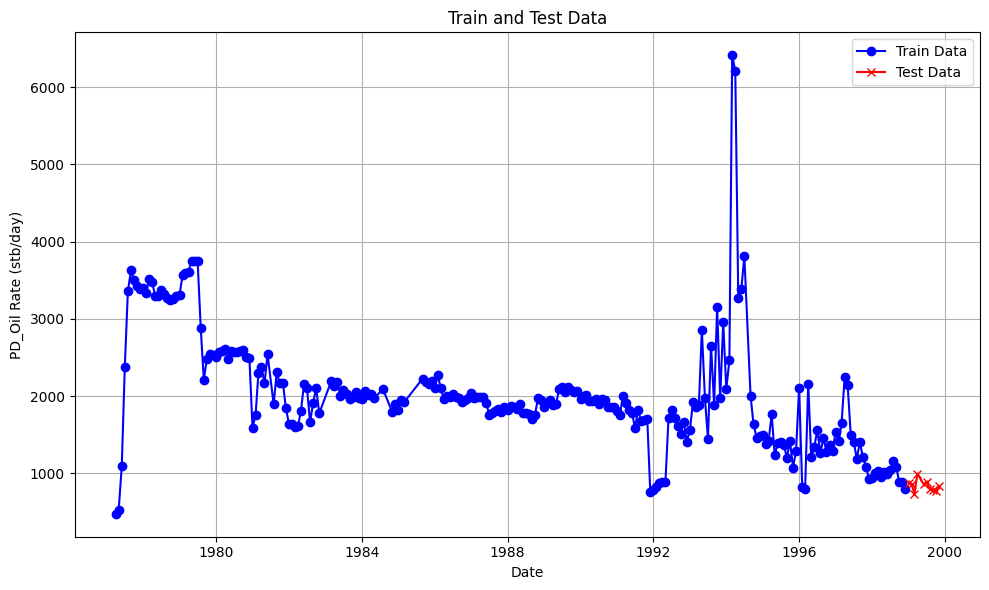

In [119]:
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are obtained from train_test_split_by_date function

# Plotting train data
plt.figure(figsize=(10, 6))

# Scatter plot for train data
plt.plot(X_train['ds'], y_train, color='blue', label='Train Data', marker='o')

# Scatter plot for test data
plt.plot(X_test['ds'], y_test, color='red', label='Test Data', marker='x')

plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('PD_Oil Rate (stb/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [120]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)

In [121]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 247 to 257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      10 non-null     datetime64[ns]
 1   y       10 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.0 bytes


In [122]:
df_test.isnull().sum()

ds    0
y     0
dtype: int64

## Fit and train model

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
import matplotlib.pyplot as plt

def plot_train_infer(X_train, y_train, forecast_ds):
    plt.figure(figsize=(10, 6))

    # Plot original training data
    plt.plot(X_train['ds'], y_train['y'], color='blue', label='Original Train Data', marker='o')

    # Plot forecasted data
    plt.plot(forecast_ds['ds'], forecast_ds['yhat'], color='red', label='Forecasted Data', marker='x')

    plt.title('Original vs Forecasted Data')
    plt.xlabel('Date')
    plt.ylabel('PD_Oil Rate (stb/day)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Prophet model

In [136]:
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    changepoint_prior_scale=0.1,#0.05
    holidays_prior_scale=15.0,
    changepoint_range=0.8
)
model.fit(df_train)

17:07:29 - cmdstanpy - INFO - Chain [1] start processing
17:07:29 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
future = model.make_future_dataframe(periods=365)
forecast_entire_data = model.predict(future)
forecast_entire_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
607,1999-11-27,908.928261,114.649182,1773.215767
608,1999-11-28,916.419130,115.797013,1693.346677
609,1999-11-29,922.467240,142.311750,1814.224288
610,1999-11-30,926.957306,68.254291,1750.952675
611,1999-12-01,929.828860,153.375672,1675.414751


In [72]:
#fig1 = model.plot(forecast)

In [126]:
X_train.shape, y_train.shape, forecast_entire_data[['ds']].shape, forecast_entire_data[['yhat']].shape

((247, 1), (247,), (612, 1), (612, 1))

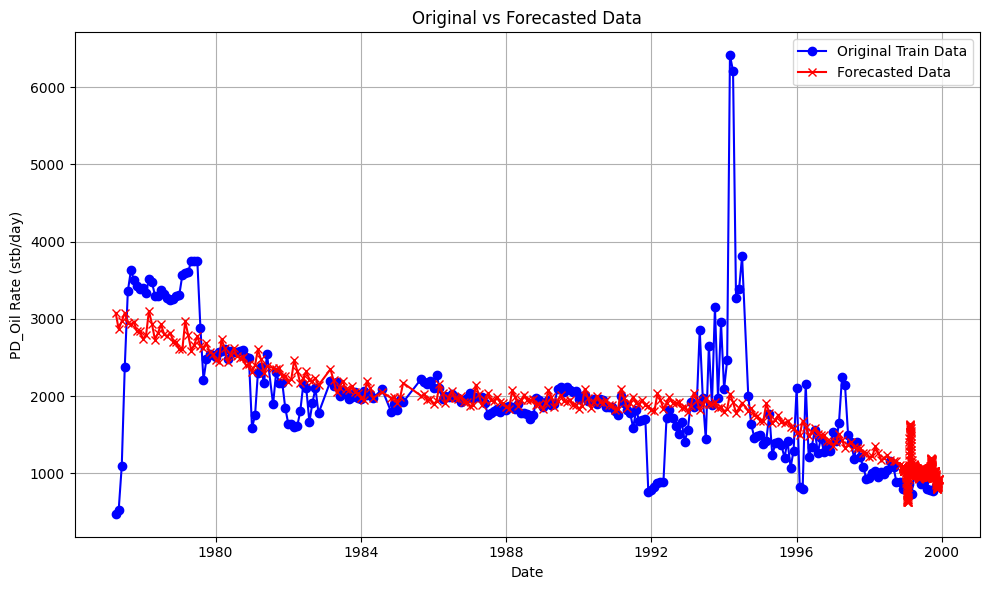

In [138]:
plot_train_infer(df_pdoil, df_pdoil, forecast_entire_data)

In [139]:
forecast_test = model.predict(X_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

X_train.shape, y_train.shape, forecast_test[['ds']].shape, forecast_test[['yhat']].shape

((247, 1), (247,), (10, 1), (10, 1))

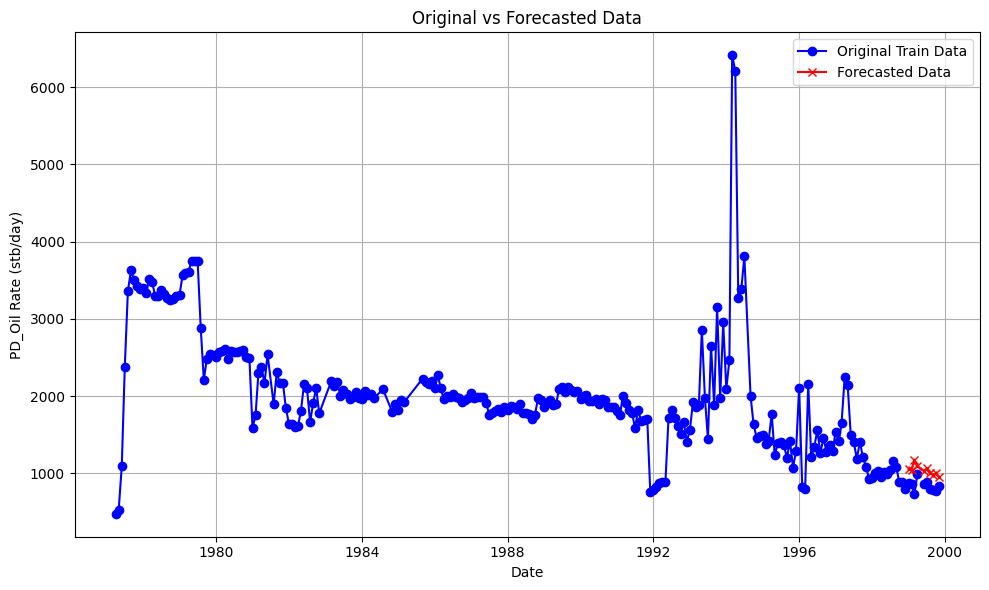

In [140]:
plot_train_infer(df_pdoil, df_pdoil, forecast_test)

In [142]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


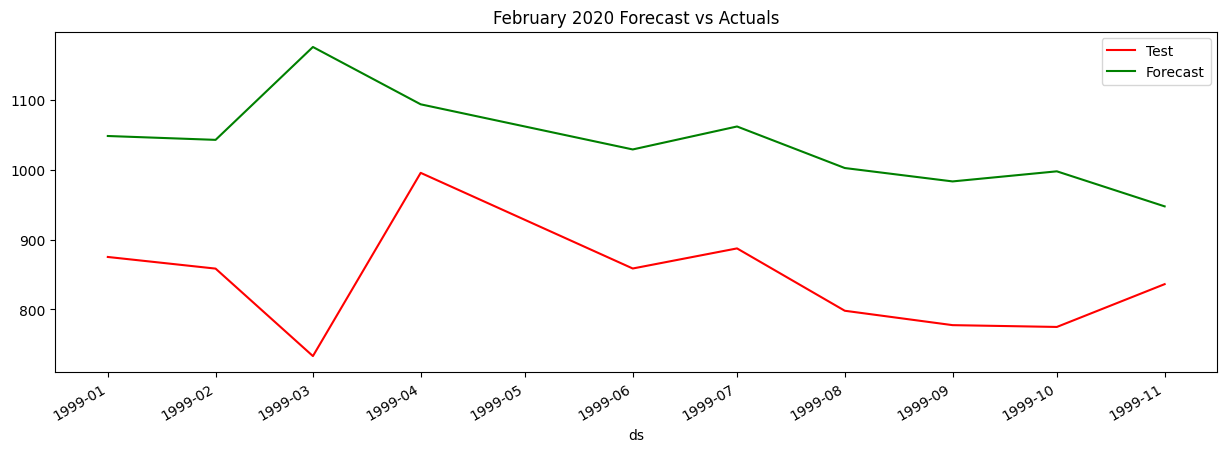

In [143]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_test.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [144]:
mape = mean_absolute_percentage_error(y_test, forecast_test['yhat'])
print("MAPE",round(mape,4))

MAPE 24.5226


#### parameter search

In [164]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
              'n_changepoints' : [100,150,200, 300, 500]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 640


In [147]:
import random

In [166]:
model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])  # Ensure it's explicitly a DataFrame

# Your loop
for p in grid:
    test = pd.DataFrame()
    #print(p)
    random.seed(0)
    hyper_model = Prophet(
        changepoint_prior_scale=p['changepoint_prior_scale'],
        holidays_prior_scale=p['holidays_prior_scale'],
        n_changepoints=p['n_changepoints'],
        seasonality_mode=p['seasonality_mode'],
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=True,
        interval_width=0.95
    )
    hyper_model.fit(df_train)
    train_forecast = hyper_model.predict(X_train)
    test = train_forecast[['ds', 'yhat']]
    
    MAPE = mean_absolute_percentage_error(y_train, abs(test['yhat']))
    #print('Mean Absolute Percentage Error(MAPE)------------------------------------', MAPE)
    
    # Concatenate the DataFrame along rows (ignore_index=True to reset index)
    model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)

18:56:30 - cmdstanpy - INFO - Chain [1] start processing


18:56:31 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_126695/3500405288.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [

In [167]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,9.711496,"{'changepoint_prior_scale': 0.8, 'holidays_pri..."
1,9.711496,"{'changepoint_prior_scale': 0.8, 'holidays_pri..."
2,9.711496,"{'changepoint_prior_scale': 0.8, 'holidays_pri..."
3,9.711496,"{'changepoint_prior_scale': 0.8, 'holidays_pri..."
4,9.711496,"{'changepoint_prior_scale': 0.8, 'holidays_pri..."


In [170]:
parameters['Parameters'].iloc[0]

{'changepoint_prior_scale': 0.8,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 500,
 'seasonality_mode': 'multiplicative'}

In [173]:
best_model = Prophet(
    seasonality_mode='multiplicative',
    #seasonality_prior_scale=10.0,  #perform parameter tuning here
    changepoint_prior_scale=0.8,
    holidays_prior_scale=0.5,
    n_changepoints=500
    #changepoint_range=0.8 #perform parameter tuning here

best_model.fit(df_train)

19:12:05 - cmdstanpy - INFO - Chain [1] start processing


19:12:06 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
future = best_model.make_future_dataframe(periods=365)
forecast_entire_data = best_model.predict(future)
forecast_entire_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
607,1999-11-27,680.606836,142.225898,1276.594777
608,1999-11-28,679.006152,145.276085,1232.143515
609,1999-11-29,673.364524,117.661811,1226.683470
610,1999-11-30,664.016488,107.554484,1245.174490
611,1999-12-01,651.441199,70.825232,1213.086449


In [ ]:
#fig1 = model.plot(forecast)

In [175]:
X_train.shape, y_train.shape, forecast_entire_data[['ds']].shape, forecast_entire_data[['yhat']].shape

((247, 1), (247,), (612, 1), (612, 1))

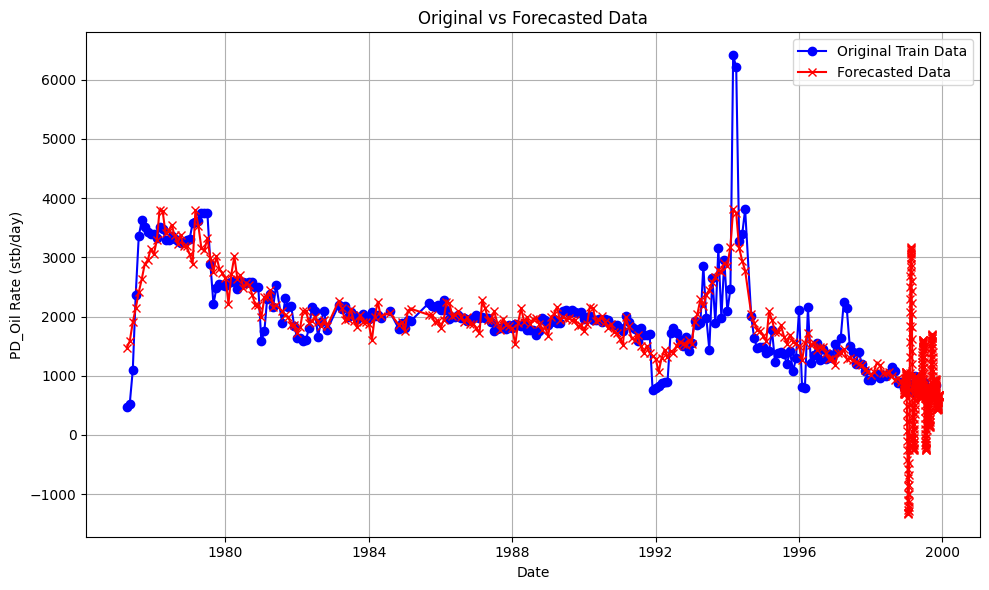

In [176]:
plot_train_infer(df_pdoil, df_pdoil, forecast_entire_data)

In [177]:
forecast_test = model.predict(X_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

X_train.shape, y_train.shape, forecast_test[['ds']].shape, forecast_test[['yhat']].shape

((247, 1), (247,), (10, 1), (10, 1))

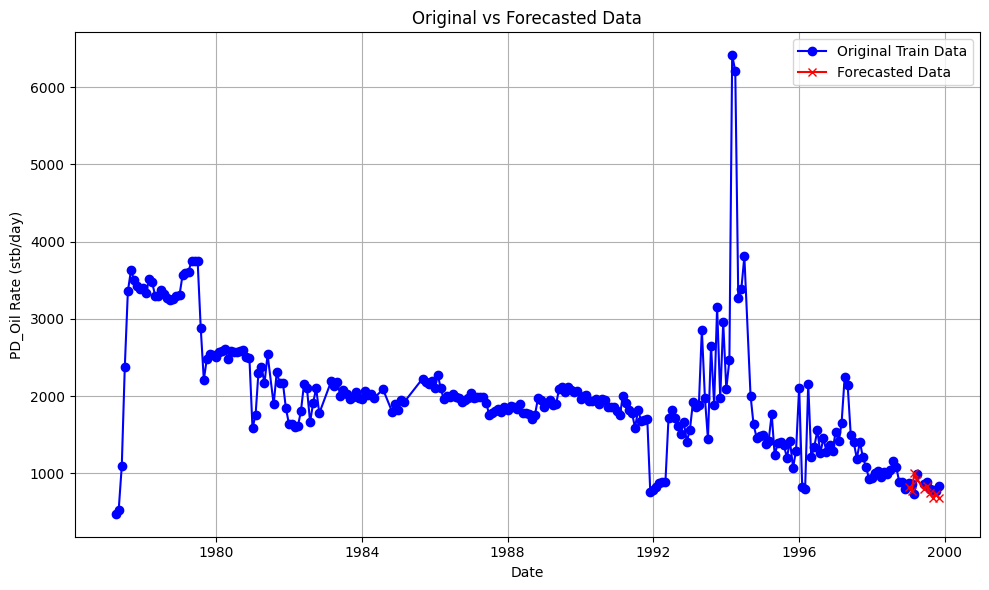

In [178]:
plot_train_infer(df_pdoil, df_pdoil, forecast_test)

In [ ]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


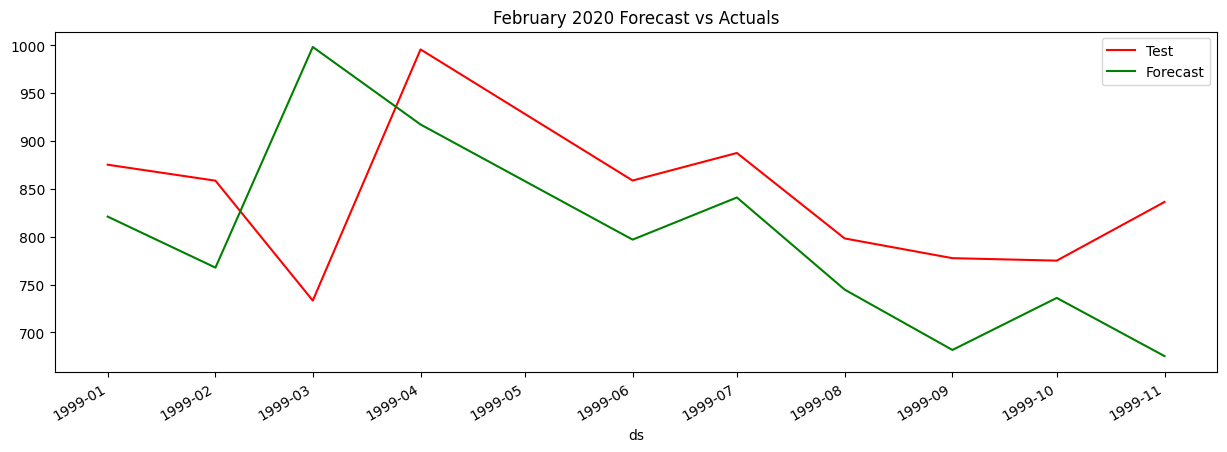

In [179]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_test.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [180]:
mape = mean_absolute_percentage_error(y_test, forecast_test['yhat'])
print("MAPE",round(mape,4))

MAPE 11.6557
